### Import Libraries

In [13]:
# ==============================
# 📦 Import Libraries
# ==============================
import os
import cv2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Add, Activation, Multiply
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,
    Dropout, Add, Activation, Multiply, BatchNormalization,
    UpSampling2D
)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import keras_tuner as kt

# Set random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

### Load and Data Preprocessing 

In [14]:
def load_images(image_dir, mask_dir, image_size=(128, 128)):
    images, masks = [], []
    for filename in sorted(os.listdir(image_dir)):
        if not filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            continue
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)  # assumes same name pattern

        if not os.path.exists(mask_path):
            print(f"Mask missing for: {filename}")
            continue

        img = load_img(img_path, color_mode='grayscale', target_size=image_size)
        mask = load_img(mask_path, color_mode='grayscale', target_size=image_size)

        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)
    if masks.ndim == 3:
        masks = np.expand_dims(masks, axis=-1)
    return images, masks


base_path = "Dataset_Generated"
image_dir = os.path.join(base_path, 'img')
mask_dir = os.path.join(base_path, 'mask')

images, masks = load_images(image_dir, mask_dir)
print(f"Loaded {len(images)} images and {len(masks)} masks.")

Loaded 170 images and 170 masks.


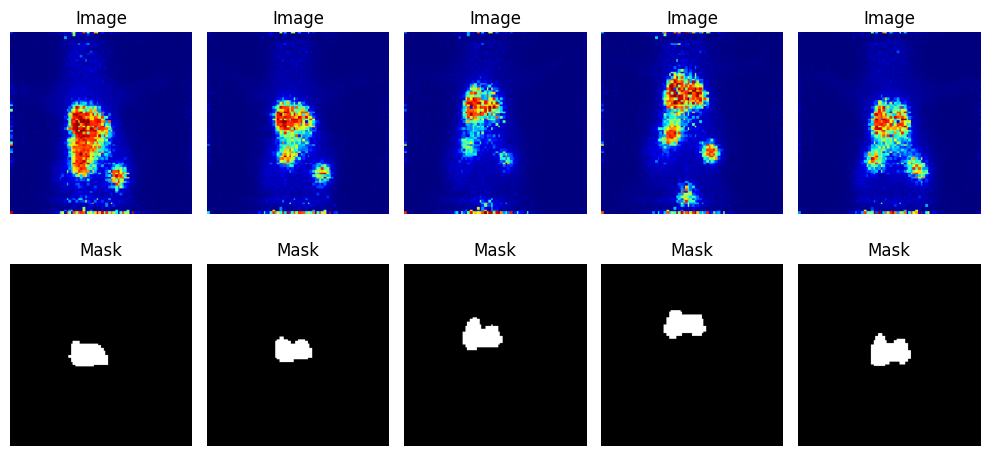

In [15]:
# Visualize some images and masks
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        if i >= len(images):
            break
        # Display image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[6*i].squeeze(), cmap='jet')
        plt.axis('off')
        plt.title("Image")
        
        # Display mask
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(masks[6*i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Mask")
    
    plt.tight_layout()
    plt.show()

visualize_samples(images, masks)

### Split Train/Test


In [16]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    images, masks, test_size=0.2, random_state=42
)
print("Training:", X_train.shape, "Testing:", X_test.shape)

Training: (136, 128, 128, 1) Testing: (34, 128, 128, 1)


### Define RResU-Net Builder

In [21]:
def recurrent_block(x, filters, t=2):
    """Simple recurrent conv block."""
    x1 = Conv2D(filters, 1, padding='same')(x)
    x1 = BatchNormalization()(x1)

    for _ in range(t):
        x1 = Activation('relu')(x1)
        x1 = Conv2D(filters, 3, padding='same')(x1)
        x1 = BatchNormalization()(x1)

    return x1


def R2_block(x, filters, t=2):
    """Recurrent + residual block."""
    out = recurrent_block(x, filters, t=t)

    shortcut = Conv2D(filters, 1, padding='same')(x)
    shortcut = BatchNormalization()(shortcut)

    out = Add()([shortcut, out])
    return Activation('relu')(out)


In [22]:
def build_rresunet_tuner(hp):
    inputs = Input((128, 128, 1))

    # Hyperparameters to tune
    num_filters = hp.Choice('num_filters', values=[16, 32])
    dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.1, 0.2])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    # Encoder
    x1 = R2_block(inputs, num_filters)
    p1 = MaxPooling2D((2, 2))(x1)
    p1 = Dropout(dropout_rate)(p1)

    x2 = R2_block(p1, num_filters * 2)
    p2 = MaxPooling2D((2, 2))(x2)
    p2 = Dropout(dropout_rate)(p2)

    x3 = R2_block(p2, num_filters * 4)
    p3 = MaxPooling2D((2, 2))(x3)
    p3 = Dropout(dropout_rate)(p3)

    x4 = R2_block(p3, num_filters * 8)
    p4 = MaxPooling2D((2, 2))(x4)
    p4 = Dropout(dropout_rate)(p4)

    # Bottleneck
    x5 = R2_block(p4, num_filters * 16)

    # Decoder (plain skip connections)
    u6 = Conv2DTranspose(num_filters * 8, (2, 2), strides=(2, 2), padding='same')(x5)
    u6 = concatenate([u6, x4])  # skip connection
    u6 = R2_block(u6, num_filters * 8)

    u7 = Conv2DTranspose(num_filters * 4, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = concatenate([u7, x3])
    u7 = R2_block(u7, num_filters * 4)

    u8 = Conv2DTranspose(num_filters * 2, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = concatenate([u8, x2])
    u8 = R2_block(u8, num_filters * 2)

    u9 = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = concatenate([u9, x1])
    u9 = R2_block(u9, num_filters)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u9)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


### Hyperparameter Tuning

In [23]:
tuner = kt.GridSearch(
    build_rresunet_tuner,
    objective='val_loss',
    max_trials=6,
    directory='rresunet_tuner_dir',
    project_name='rresunet_fixed'
)

tuner.search_space_summary()

tuner.search(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=3,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')]
)

tuner.results_summary()

Reloading Tuner from rresunet_tuner_dir\rresunet_fixed\tuner0.json
Search space summary
Default search space size: 3
num_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32], 'ordered': True}
dropout_rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
Results summary
Results in rresunet_tuner_dir\rresunet_fixed
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.1
learning_rate: 0.001
Score: 0.03851201757788658

Trial 4 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.0945957824587822

Trial 5 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.2
learning_rate: 0.0001
Score: 0.0993259996175766

Trial 0 summary
Hyperparameters:
num_filters: 16
dropout_rate: 0.0
learning_rate: 0.001
Score: 0.1205411478877

In [24]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"""
Best Hyperparameters:
num_filters = {best_hps.get('num_filters')}
dropout_rate = {best_hps.get('dropout_rate')}
learning_rate = {best_hps.get('learning_rate')}
""")


Best Hyperparameters:
num_filters = 16
dropout_rate = 0.1
learning_rate = 0.001



In [25]:
model = build_rresunet_tuner(best_hps)
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=4,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])



Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8225 - loss: 0.5216 - val_accuracy: 0.9729 - val_loss: 0.5804
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9796 - loss: 0.2193 - val_accuracy: 0.9732 - val_loss: 0.4083
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 694ms/step - accuracy: 0.9878 - loss: 0.1506 - val_accuracy: 0.9732 - val_loss: 0.2802
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 481ms/step - accuracy: 0.9913 - loss: 0.1086 - val_accuracy: 0.9732 - val_loss: 0.2030
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 578ms/step - accuracy: 0.9931 - loss: 0.0817 - val_accuracy: 0.9732 - val_loss: 0.1680
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 397ms/step - accuracy: 0.9935 - loss: 0.0645 - val_accuracy: 0.9732 - val_loss: 0.1571
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - accuracy: 0.9937 - loss: 0.0527 - val_accuracy: 0.9732 - val_loss: 0.1527
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 354ms/step - accuracy: 0.9946 - loss: 0.0429 - val_accuracy: 

In [26]:
# %%
model.save('model_4_rresunet.h5')

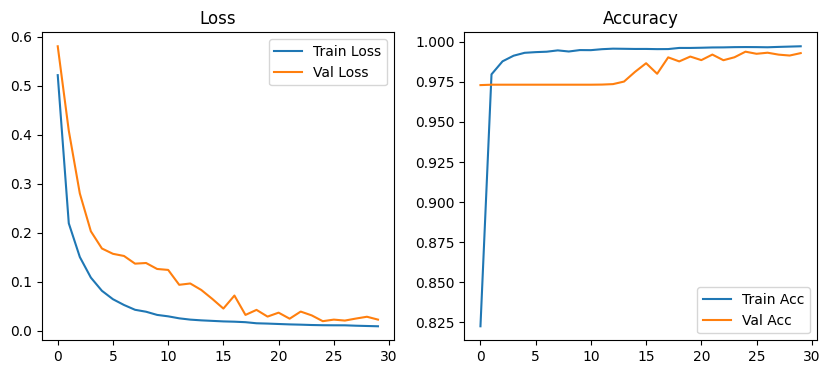

In [27]:
# %%
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [17]:
from tensorflow.keras.models import load_model

model = load_model('z_models/model_4_rresunet.h5', compile=False)


In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)

preds_test = model.predict(X_test)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

dice_scores = []
precisions = []
recalls = []
accuracies = []

TP_total = 0
TN_total = 0
FP_total = 0
FN_total = 0

for i in range(len(X_test)):
    y_true = y_test[i].squeeze()
    y_pred = preds_test_t[i].squeeze()
    
    # Flatten for sklearn metrics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    dice_scores.append(dice_coef(y_true, y_pred))
    precisions.append(precision_score(y_true_flat, y_pred_flat))
    recalls.append(recall_score(y_true_flat, y_pred_flat))
    accuracies.append(accuracy_score(y_true_flat, y_pred_flat))
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat, labels=[0,1]).ravel()
    TP_total += tp
    TN_total += tn
    FP_total += fp
    FN_total += fn

print(f"Average Dice Coefficient: {np.mean(dice_scores):.3f}")
print(f"Average Precision: {np.mean(precisions):.3f}")
print(f"Average Recall: {np.mean(recalls):.3f}")
print(f"Average Accuracy: {np.mean(accuracies):.3f}")

print("\nTotal Confusion Matrix:")
print(f"TP: {TP_total}, TN: {TN_total}, FP: {FP_total}, FN: {FN_total}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Average Dice Coefficient: 0.905
Average Precision: 0.855
Average Recall: 0.970
Average Accuracy: 0.994

Total Confusion Matrix:
TP: 14452, TN: 539537, FP: 2580, FN: 487


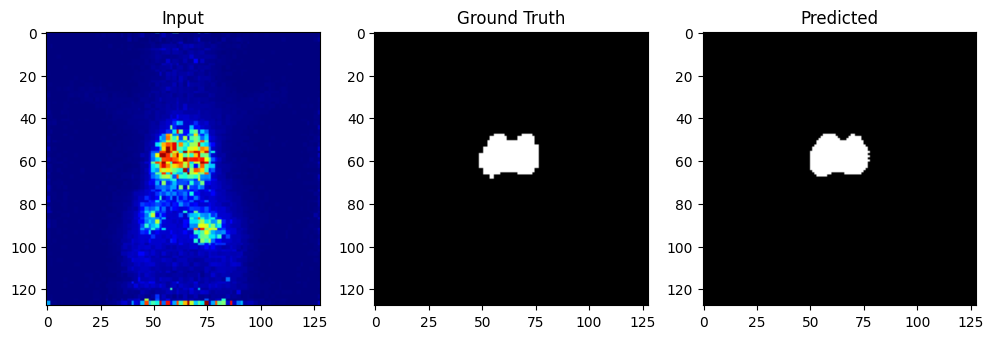

In [23]:
# -------------------------------
# Visualize a Random Prediction
# -------------------------------
import random
ix = random.randint(0, len(X_test) - 1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(X_test[ix].squeeze(), cmap='jet'); plt.title('Input')
plt.subplot(1,3,2); plt.imshow(y_test[ix].squeeze(), cmap='gray'); plt.title('Ground Truth')
plt.subplot(1,3,3); plt.imshow(preds_test_t[ix].squeeze(), cmap='gray'); plt.title('Predicted')
plt.show()